In [800]:
import cv2
import numpy
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [801]:
path = r"C:\cllg\nural networks\Parkinsons\data"
INPSIZE = (200,200)

In [802]:
dx = []
dy = []

In [803]:
npath = os.path.join(path,"nm")

for i in tqdm(os.listdir(npath)):
    dy.append(0)
    img = cv2.cvtColor(cv2.imread(os.path.join(npath,i)),cv2.COLOR_BGR2GRAY)
#     img = img[round(img.shape[0]*.25):round(img.shape[0]*.65), round(img.shape[1]*.30):round(img.shape[1]*.70)]
    img = cv2.resize(img,INPSIZE)
    dx.append(img)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:10<00:00, 19.29it/s]


In [804]:
npath = os.path.join(path,"pd")

for i in tqdm(os.listdir(npath)):
    dy.append(1)
    img = cv2.cvtColor(cv2.imread(os.path.join(npath,i)),cv2.COLOR_BGR2GRAY)
#     img = img[round(img.shape[0]*.25):round(img.shape[0]*.65), round(img.shape[1]*.30):round(img.shape[1]*.70)]
    img = cv2.resize(img,INPSIZE)
    dx.append(img)

100%|████████████████████████████████████████████████████████████████████████████████| 197/197 [00:10<00:00, 18.62it/s]


In [1010]:
x = np.array(dx)
y = np.array(dy)

In [1011]:
x.shape, y.shape

((397, 200, 200), (397,))

In [1020]:
p = np.random.permutation(y.shape[0])
x = x[p]
y = y[p]

## train-70, val-20, test-10

In [1021]:
splitval = round(y.shape[0] * .20)
splittes = round(y.shape[0] * .10)
splitval, splittes

(79, 40)

In [1022]:
xval = x[:splitval]
yval = y[:splitval]

x = x[splitval:]
y = y[splitval:]

xtes = x[:splittes]
ytes = y[:splittes]

x = x[splittes:]
y = y[splittes:]

In [1023]:
np.unique(y,return_counts=True),y.shape,np.unique(yval,return_counts=True),yval.shape,np.unique(ytes,return_counts=True),ytes.shape

((array([0, 1]), array([136, 142], dtype=int64)),
 (278,),
 (array([0, 1]), array([42, 37], dtype=int64)),
 (79,),
 (array([0, 1]), array([22, 18], dtype=int64)),
 (40,))

In [1024]:
i = 0

1


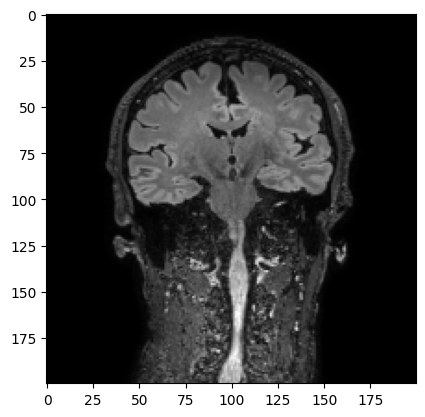

In [1025]:
plt.imshow(x[i],cmap="gray")
print(y[i])
i+=1

In [1026]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback, LearningRateScheduler

In [1027]:
BATCH_SIZE = 32

train_generator = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=[0.7,1],
    rotation_range=10,
    brightness_range=[.6,1.4],
    fill_mode = "nearest",
    )

In [1056]:
model = Sequential([
    Conv2D(8,(3,3), activation = "leaky_relu", input_shape=INPSIZE+(1,)),
    MaxPooling2D(),
    
    Conv2D(8,(3,3), activation = "leaky_relu"),
    MaxPooling2D(),
    
    Conv2D(16,(3,3), activation = "leaky_relu"),
    MaxPooling2D(),
    
    Conv2D(32,(3,3), activation = "leaky_relu"),
    MaxPooling2D(),
    
    Flatten(),
    
    Dense(16, activation="leaky_relu"),
    Dense(8, activation="leaky_relu"),
    Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_229 (Conv2D)         (None, 198, 198, 8)       80        
                                                                 
 max_pooling2d_229 (MaxPooli  (None, 99, 99, 8)        0         
 ng2D)                                                           
                                                                 
 conv2d_230 (Conv2D)         (None, 97, 97, 8)         584       
                                                                 
 max_pooling2d_230 (MaxPooli  (None, 48, 48, 8)        0         
 ng2D)                                                           
                                                                 
 conv2d_231 (Conv2D)         (None, 46, 46, 16)        1168      
                                                                 
 max_pooling2d_231 (MaxPooli  (None, 23, 23, 16)     

In [1057]:
model.compile(optimizer=tf.optimizers.Adam(1e-3), loss=tf.losses.binary_crossentropy, metrics=["acc"])

In [1058]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            
def lrDecay(epoch, lr):
    if(epoch <= 10):
        return lr
    else:
        return lr * .95

In [1059]:
# lrs = []
# lr = 1e-3
# for i in range(100):
#     lr = lrDecay(i,lr)
#     lrs.append(lr)

# plt.plot(lrs)

In [1060]:
hist = model.fit(train_generator.flow(np.reshape(x, (x.shape[0], x.shape[1], x.shape[2], 1)), y, batch_size=BATCH_SIZE,shuffle=True),
                 steps_per_epoch=len(y) // BATCH_SIZE,
                 epochs=100,
                 callbacks=[early_stopping, LearningRateScheduler(lrDecay)],
                 validation_data=(xval/255,yval),
                )

Epoch 1/100
8/8 [==============================] - 4s 319ms/step - loss: 0.6925 - acc: 0.5000 - val_loss: 0.6955 - val_acc: 0.4684 - lr: 0.0010
Epoch 2/100
8/8 [==============================] - 2s 281ms/step - loss: 0.6928 - acc: 0.5122 - val_loss: 0.6953 - val_acc: 0.4684 - lr: 0.0010
Epoch 3/100
8/8 [==============================] - 2s 299ms/step - loss: 0.6934 - acc: 0.4878 - val_loss: 0.6924 - val_acc: 0.4937 - lr: 0.0010
Epoch 4/100
8/8 [==============================] - 2s 291ms/step - loss: 0.6922 - acc: 0.5508 - val_loss: 0.6925 - val_acc: 0.6076 - lr: 0.0010
Epoch 5/100
8/8 [==============================] - 2s 295ms/step - loss: 0.6915 - acc: 0.5691 - val_loss: 0.6919 - val_acc: 0.4810 - lr: 0.0010
Epoch 6/100
8/8 [==============================] - 2s 279ms/step - loss: 0.6909 - acc: 0.5244 - val_loss: 0.6931 - val_acc: 0.4684 - lr: 0.0010
Epoch 7/100
8/8 [==============================] - 2s 295ms/step - loss: 0.6911 - acc: 0.5569 - val_loss: 0.6878 - val_acc: 0.6962 - lr:

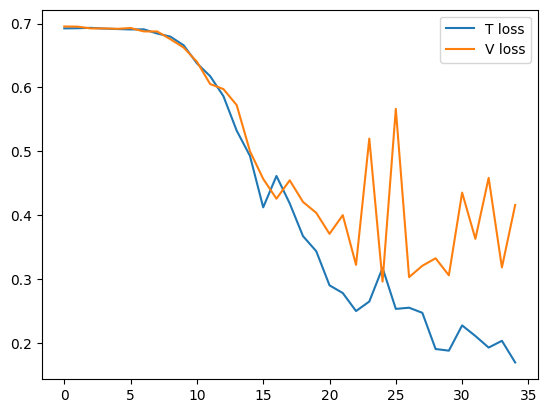

In [1061]:
plt.plot(hist.history["loss"], label="T loss")
plt.plot(hist.history["val_loss"], label="V loss")
plt.legend()
plt.show()

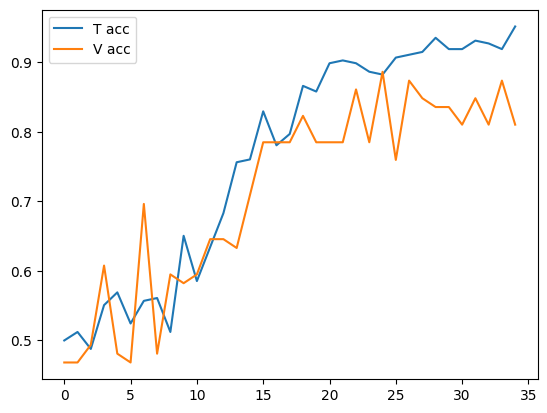

In [1062]:
plt.plot(hist.history["acc"], label="T acc")
plt.plot(hist.history["val_acc"], label="V acc")
plt.legend()
plt.show()

In [1063]:
i = 0

1/1 [==============================] - 0s 315ms/step
pred: Normal, actual: Normal
Correct


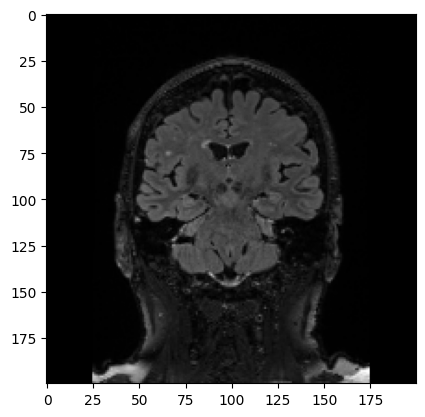

In [1064]:
plt.imshow(xtes[i], cmap="gray")

cl = ["Normal","Parkinsons"]
pred = round(model.predict(np.array([xtes[i]/255]))[0,0])
print(f"pred: {cl[pred]}, actual: {cl[ytes[i]]}")

if pred == ytes[i]:
    print("Correct")
else:
    print("Wrong")

i += 1

In [1065]:
# model.save(r"C:\cllg\nural networks\Parkinsons\models\model.h5")

In [1066]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

In [1067]:
pred = model.predict(x/255).round().T[0]

9/9 [==============================] - 2s 172ms/step


In [1068]:
confusion_matrix(y,pred)

array([[127,   9],
       [ 20, 122]], dtype=int64)

In [1069]:
cnnAccTr = accuracy_score(y,pred).round(2)
cnnAccTr

0.9

In [1070]:
pred = model.predict(xtes/255).round().T[0]

2/2 [==============================] - 0s 45ms/step


In [1071]:
confusion_matrix(ytes,pred)

array([[21,  1],
       [ 4, 14]], dtype=int64)

In [1072]:
print(classification_report(ytes,pred))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89        22
           1       0.93      0.78      0.85        18

    accuracy                           0.88        40
   macro avg       0.89      0.87      0.87        40
weighted avg       0.88      0.88      0.87        40



In [1073]:
cnnAcc = accuracy_score(ytes,pred).round(2)
cnnAcc

0.88

# Finetune

In [1046]:
model.compile(optimizer=tf.optimizers.Adam(1e-6), loss=tf.losses.binary_crossentropy, metrics=["acc"])
hist = model.fit(x/255,y,validation_data=(xval/255,yval),epochs=5)

Epoch 1/5
9/9 [==============================] - 5s 424ms/step - loss: 0.0931 - acc: 0.9712 - val_loss: 0.1622 - val_acc: 0.9620
Epoch 2/5
9/9 [==============================] - 4s 404ms/step - loss: 0.0923 - acc: 0.9712 - val_loss: 0.1622 - val_acc: 0.9620
Epoch 3/5
9/9 [==============================] - 4s 402ms/step - loss: 0.0916 - acc: 0.9748 - val_loss: 0.1624 - val_acc: 0.9620
Epoch 4/5
9/9 [==============================] - 4s 402ms/step - loss: 0.0909 - acc: 0.9748 - val_loss: 0.1624 - val_acc: 0.9620
Epoch 5/5
9/9 [==============================] - 4s 399ms/step - loss: 0.0903 - acc: 0.9748 - val_loss: 0.1624 - val_acc: 0.9620


## Augmented data

In [1047]:
ad = train_generator.flow(xval.reshape(xval.shape[0],xval.shape[1], xval.shape[2], 1),yval,shuffle=True,batch_size=yval.shape[0])
adx,ady = ad.next()
pred = model.predict(adx).round().T[0]

print(confusion_matrix(ady,pred))
print(classification_report(ady,pred))

3/3 [==============================] - 0s 99ms/step
[[37  5]
 [ 2 35]]
              precision    recall  f1-score   support

           0       0.95      0.88      0.91        42
           1       0.88      0.95      0.91        37

    accuracy                           0.91        79
   macro avg       0.91      0.91      0.91        79
weighted avg       0.91      0.91      0.91        79



In [1048]:
dx = np.array(dx)
dy = np.array(dy)

In [1049]:
ad = train_generator.flow(dx.reshape(dx.shape[0],dx.shape[1], dx.shape[2], 1),dy,shuffle=True,batch_size=dy.shape[0])
adx,ady = ad.next()
pred = model.predict(adx).round().T[0]

print(confusion_matrix(ady,pred))
print(classification_report(ady,pred))

13/13 [==============================] - 2s 133ms/step
[[192   8]
 [  4 193]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       200
           1       0.96      0.98      0.97       197

    accuracy                           0.97       397
   macro avg       0.97      0.97      0.97       397
weighted avg       0.97      0.97      0.97       397



In [1050]:
i = 0

1


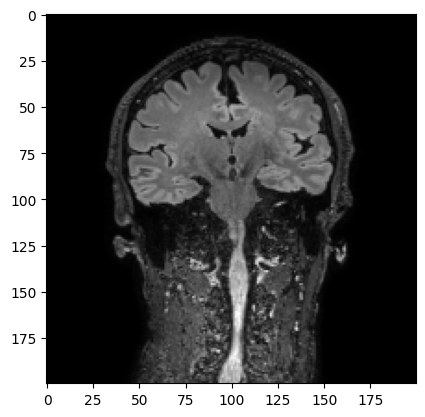

In [1051]:
plt.imshow(x[i], cmap="gray")
print(y[i])
i += 1

In [1052]:
ad = train_generator.flow(xval.reshape(xval.shape[0],xval.shape[1], xval.shape[2], 1),yval,shuffle=True,batch_size=yval.shape[0])

In [1053]:
i = 0

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_44/conv2d_220/LeakyRelu' defined at (most recent call last):
    File "c:\users\yash\appdata\local\programs\python\python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\users\yash\appdata\local\programs\python\python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\users\yash\appdata\local\programs\python\python39\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "c:\users\yash\appdata\local\programs\python\python39\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "c:\users\yash\appdata\local\programs\python\python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Yash\AppData\Local\Temp\ipykernel_11220\2561166909.py", line 4, in <module>
      pred = round(model.predict(np.array([aimg]))[0][0])
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 2382, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 2169, in predict_function
      return step_function(self, iterator)
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 2155, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 2143, in run_step
      outputs = model.predict_step(data)
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
      return self(x, training=False)
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\keras\engine\sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\yash\appdata\local\programs\python\python39\lib\site-packages\keras\layers\convolutional\base_conv.py", line 321, in call
      return self.activation(outputs)
Node: 'sequential_44/conv2d_220/LeakyRelu'
convolution input must be 4-dimensional: [1,200,200]
	 [[{{node sequential_44/conv2d_220/LeakyRelu}}]] [Op:__inference_predict_function_310216]

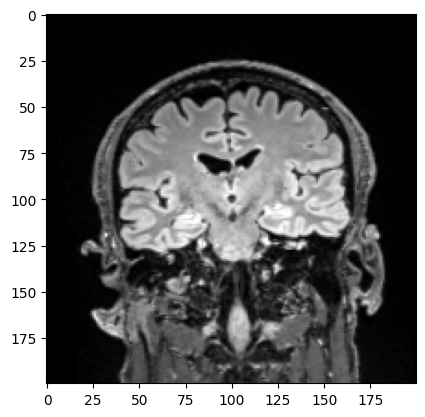

In [1054]:
aimg = np.reshape(ad[0][0][i],(xval[0].shape))

plt.imshow(aimg, cmap="gray")
pred = round(model.predict(np.array([aimg]))[0][0])

print(f"pred: {cl[pred]}, actual: {cl[ad[0][1][i]]}")

if pred == ad[0][1][i]:
    print("Correct")
else:
    print("Wrong")

i += 1

# Data preprocessing for other models

In [186]:
x.shape

(337, 200, 200)

In [187]:
dtx = x.reshape(x.shape[0],-1)
dtxval = xval.reshape(xval.shape[0],-1)

In [188]:
dtx.shape

(337, 40000)

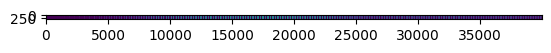

In [189]:
plt.imshow(dtx)

# Decision Tree

In [190]:
from sklearn.tree import DecisionTreeClassifier

In [191]:
dt = DecisionTreeClassifier()
dt.fit(dtx,y)

DecisionTreeClassifier()

### Train data

In [192]:
i = 0

In [193]:
print(f"index:{i}  pred:{dt.predict(np.array([dtx[i]]))}  actual:{y[i]}")
i+=1

index:0  pred:[1]  actual:1


test data

In [194]:
i = 0

In [195]:
print(f"index:{i}  pred:{dt.predict(np.array([dtxval[i]]))}  actual:{yval[i]}")
i+=1

index:0  pred:[1]  actual:0


## Training report

In [196]:
preds = dt.predict(dtx)

cm = confusion_matrix(y, preds)
cr = classification_report(y, preds)
print(cm)
print(cr)

[[174   0]
 [  0 163]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       174
           1       1.00      1.00      1.00       163

    accuracy                           1.00       337
   macro avg       1.00      1.00      1.00       337
weighted avg       1.00      1.00      1.00       337



In [197]:
dtAccTr = accuracy_score(y,preds).round(2)
dtAccTr

1.0

## Testing Report

In [198]:
preds = dt.predict(dtxval)

cm = confusion_matrix(yval, preds)
cr = classification_report(yval, preds)
print(cm)
print(cr)

[[19  7]
 [10 24]]
              precision    recall  f1-score   support

           0       0.66      0.73      0.69        26
           1       0.77      0.71      0.74        34

    accuracy                           0.72        60
   macro avg       0.71      0.72      0.71        60
weighted avg       0.72      0.72      0.72        60



In [199]:
dtAcc = accuracy_score(yval, preds).round(2)
dtAcc

0.72

# Random Forest

In [200]:
from sklearn.ensemble import RandomForestClassifier

In [201]:
rf = RandomForestClassifier()
rf.fit(dtx,y)

RandomForestClassifier()

In [202]:
i = 0

In [203]:
print(f"index:{i}  pred:{rf.predict(np.array([dtxval[i]]))}  actual:{yval[i]}")
i+=1

index:0  pred:[1]  actual:0


## Training Report

In [204]:
preds = rf.predict(dtx)

cm = confusion_matrix(y, preds)
cr = classification_report(y, preds)
print(cm)
print(cr)

[[174   0]
 [  0 163]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       174
           1       1.00      1.00      1.00       163

    accuracy                           1.00       337
   macro avg       1.00      1.00      1.00       337
weighted avg       1.00      1.00      1.00       337



In [205]:
rfAccTr = accuracy_score(y,preds).round(2)
rfAccTr

1.0

## Testing Report

In [206]:
preds = rf.predict(dtxval)

cm = confusion_matrix(yval, preds)
cr = classification_report(yval, preds)
print(cm)
print(cr)

[[24  2]
 [ 4 30]]
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        26
           1       0.94      0.88      0.91        34

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



In [207]:
rfAcc = accuracy_score(yval, preds).round(2)
rfAcc

0.9

# SVM

In [208]:
from sklearn.svm import SVC

In [209]:
svm = SVC()
svm.fit(dtx,y)

SVC()

In [210]:
i = 0

In [211]:
print(f"index:{i}  pred:{svm.predict(np.array([dtxval[i]]))}  actual:{yval[i]}")
i+=1

index:0  pred:[1]  actual:0


## Training Report

In [212]:
preds = svm.predict(dtx)

cm = confusion_matrix(y, preds)
cr = classification_report(y, preds)
print(cm)
print(cr)

[[166   8]
 [  3 160]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       174
           1       0.95      0.98      0.97       163

    accuracy                           0.97       337
   macro avg       0.97      0.97      0.97       337
weighted avg       0.97      0.97      0.97       337



In [213]:
svmAccTr = accuracy_score(y,preds).round(2)
svmAccTr

0.97

## Testing Report

In [214]:
preds = svm.predict(dtxval)

cm = confusion_matrix(yval, preds)
cr = classification_report(yval, preds)
print(cm)
print(cr)

[[23  3]
 [ 2 32]]
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        26
           1       0.91      0.94      0.93        34

    accuracy                           0.92        60
   macro avg       0.92      0.91      0.91        60
weighted avg       0.92      0.92      0.92        60



In [215]:
svmAcc = accuracy_score(yval, preds).round(2)
svmAcc

0.92

# Graphs

In [216]:
barData = [cnnAcc, dtAcc, rfAcc, svmAcc]
barDataTr = [cnnAccTr, dtAccTr, rfAccTr, svmAccTr]
barData , barDataTr

([1.0, 0.72, 0.9, 0.92], [0.97, 1.0, 1.0, 0.97])

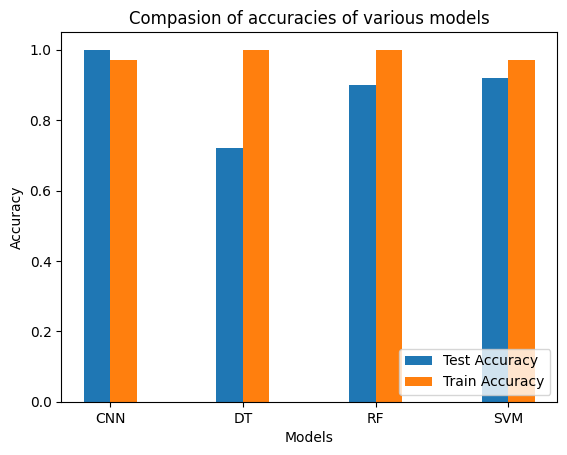

In [226]:
plt.bar( np.arange(len(barData))-.1 ,barData, width=.20,  label="Test Accuracy")
plt.bar( np.arange(len(barDataTr))+.1 ,barDataTr, width=.20, label="Train Accuracy")
plt.xticks(np.arange(len(barData)), labels=["CNN", "DT", "RF", "SVM"])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Compasion of accuracies of various models")
plt.legend(loc = 4)
plt.show()

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras import models

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))  # binary classification (Parkinson or not)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2 
)

# Set your image directory paths
train_generator = train_datagen.flow_from_directory(
    'C:/cllg/nural networks/Parkinsons/data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

history = model.fit(train_generator, epochs=10, steps_per_epoch=len(train_generator))

model.save(r"C:\cllg\nural networks\Parkinsons\models\parkinson_classifierVGG16.h5")


Found 397 images belonging to 2 classes.
Epoch 1/10
 9/13 [===================>..........] - ETA: 56s - loss: 3.6235 - accuracy: 0.4721 

KeyboardInterrupt: 

In [ ]:
plt.plot(hist.history["loss"], label="T loss")
plt.plot(hist.history["val_loss"], label="V loss")
plt.legend()
plt.show()

In [ ]:
plt.plot(hist.history["acc"], label="T loss")
plt.plot(hist.history["val_acc"], label="V loss")
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping, Callback

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))  # binary classification (Parkinson or not)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split = .2
)

train_generator = train_datagen.flow_from_directory(
    r'C:\cllg\nural networks\Parkinsons\data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
       r'C:\cllg\nural networks\Parkinsons\data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

hist = model.fit(train_generator, epochs=1000, steps_per_epoch=len(train_generator), validation_data=validation_generator, validation_steps=len(validation_generator), callbacks=[early_stopping])

model.save(r'C:\cllg\nural networks\Parkinsons\models\parkinson_classifierVGG16.h5')


Found 318 images belonging to 2 classes.
Found 79 images belonging to 2 classes.
Epoch 1/1000
10/10 [==============================] - 117s 12s/step - loss: 2.0299 - accuracy: 0.5440 - val_loss: 1.6561 - val_accuracy: 0.5063
Epoch 2/1000
10/10 [==============================] - 135s 14s/step - loss: 1.3248 - accuracy: 0.6352 - val_loss: 0.7925 - val_accuracy: 0.5063
Epoch 3/1000
10/10 [==============================] - 137s 14s/step - loss: 0.5637 - accuracy: 0.7390 - val_loss: 0.6106 - val_accuracy: 0.7342
Epoch 4/1000
10/10 [==============================] - ETA: 0s - loss: 0.4216 - accuracy: 0.7956 